# 1. 개발 환경 설정

### 1.1 필수 라이브러리 설치하기

In [1]:
!pip3 install -q -U transformers==4.38.2
!pip3 install -q -U datasets==2.18.0
!pip3 install -q -U bitsandbytes==0.42.0
!pip3 install -q -U peft==0.9.0
!pip3 install --upgrade peft
!pip3 install -q -U trl==0.7.11
!pip3 install -q -U accelerate==0.27.2

^C
ERROR: Operation cancelled by user
  Obtaining dependency information for peft from https://files.pythonhosted.org/packages/19/99/c5e0292a6d2a62e95c3dfe674ce9e8f8a9fe5d4835d3c9bb9b3e016f02ae/peft-0.11.1-py3-none-any.whl.metadata
  Using cached peft-0.11.1-py3-none-any.whl.metadata (13 kB)
Using cached peft-0.11.1-py3-none-any.whl (251 kB)
  Attempting uninstall: peft
    Found existing installation: peft 0.9.0
    Uninstalling peft-0.9.0:
      Successfully uninstalled peft-0.9.0


### 1.2 Import modules

In [2]:
import pandas as pd
import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
import pytorch_lightning as pl
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.

from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline, TrainingArguments
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

from peft import LoraConfig, PeftModel
from trl import SFTTrainer

import wandb # 모델 학습 과정을 손쉽게 Tracking하고, 시각화할 수 있는 라이브러리입니다.

os.environ["TOKENIZERS_PARALLELISM"] = "true"


### 1.3 Huggingface 로그인

In [4]:
from huggingface_hub import notebook_login
notebook_login()

# 2. Dataset 생성 및 준비

### 2.1 데이터셋 로드

In [2]:
# config에 저장된 데이터 경로를 통해 train과 validation data를 불러옵니다.
data_path = '/data/ephemeral/home/data'

# train data의 구조와 내용을 확인합니다.
train_df = pd.read_csv(os.path.join(data_path,'shuffled_merged_file.csv'))

# validation data의 구조와 내용을 확인합니다.
val_df = pd.read_csv(os.path.join(data_path,'dev.csv'))

# 3. Solar 파인튜닝

### 3.1 학습용 프롬프트 조정

In [3]:
def generate_prompt(row):
    topic = row['topic'] if 'topic' in row else ''
    
    prompt = f"<s> <|im_start|>system\n주제를 참고해 다음 대화를 요약해주세요:\n\ntopic: {topic}\n\ndialogue: {row['dialogue']}\n<|im_end|>\n<|im_start|>assistant\n요약: {row['summary']}\n<|im_end|> </s>"
    
    return prompt

In [3]:
def generate_prompt(row):#토픽 추출용
    topic = row['topic'] if 'topic' in row else ''
    
    prompt = f"<s> <|im_start|>system\n다음 대화의 토픽을 찾으세요:\n\ndialogue: {row['dialogue']}\n<|im_end|>\n<|im_start|>assistant\ntopic: {topic}\n<|im_end|> </s>"
    
    return prompt

In [4]:
train_df['prompt'] = train_df.apply(generate_prompt, axis=1)
val_df['prompt'] = val_df.apply(generate_prompt, axis=1)

train_data = train_df['prompt']
val_data = val_df['prompt']

### 3.2 QLoRA 설정

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BitsAndBytesConfig
from peft import LoraConfig, PeftModel, get_peft_model, prepare_model_for_kbit_training
import torch

BASE_MODEL = "beomi/Solar-Ko-Recovery-11B"

# LoRA 설정
lora_config = LoraConfig(
    r=6,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

# 양자화 설정
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# 모델 로드
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    device_map={"": "cuda"},
    quantization_config=bnb_config,
    torch_dtype=torch.float16,
)


model = prepare_model_for_kbit_training(model)

# QLora 적용
model = get_peft_model(model, lora_config)

# 토크나이저 설정
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, add_special_tokens=True)
#model.resize_token_embeddings(len(tokenizer))

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

평균 시퀀스 길이: 283.83803863298664
중앙값 시퀀스 길이: 263.0
최대 시퀀스 길이: 1395
최소 시퀀스 길이: 59


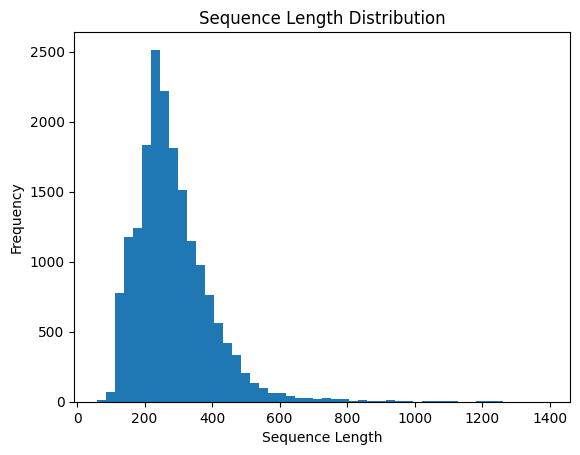

In [6]:
from transformers import AutoTokenizer
import numpy as np
import matplotlib.pyplot as plt

# 데이터 토큰화
tokenized_data = tokenizer(train_df['prompt'].tolist())

# 시퀀스 길이 계산
seq_lengths = [len(seq) for seq in tokenized_data['input_ids']]

# 시퀀스 길이 통계량 출력
print(f"평균 시퀀스 길이: {np.mean(seq_lengths)}")
print(f"중앙값 시퀀스 길이: {np.median(seq_lengths)}")
print(f"최대 시퀀스 길이: {np.max(seq_lengths)}")
print(f"최소 시퀀스 길이: {np.min(seq_lengths)}")

# 시퀀스 길이 히스토그램 그리기
plt.hist(seq_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Sequence Length Distribution')
plt.show()

### 3.3 Trainer 실행

In [6]:
wandb_key = ''
wandb.login(key=wandb_key, relogin=True)

# set the wandb project where this run will be logged
os.environ["WANDB_ENTITY"] = 'upstage-ai-comp'

# set the wandb project where this run will be logged
os.environ["WANDB_PROJECT"] = ''

# save your trained model checkpoint to wandb
os.environ["WANDB_LOG_MODEL"] = "true"

# turn off watch to log faster
os.environ["WANDB_WATCH"] = "all"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /data/ephemeral/home/.netrc


In [7]:
from datasets import Dataset, load_metric
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# 훈련 데이터 로드
train_data = Dataset.from_dict({"prompt": train_df['prompt']})

# 검증 데이터 로드
val_data = Dataset.from_dict({"prompt": val_df['prompt']})

def formattingfunc(example):
    return example['prompt']

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    max_seq_length=512,
    args=TrainingArguments(
        output_dir="outputs",
        num_train_epochs=3,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=4,
        eval_accumulation_steps=4,
        dataloader_num_workers=0,
        optim="adamw_torch_fused",
        warmup_steps=0.05,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=100,
        push_to_hub=False,
        evaluation_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
        max_grad_norm=0.3,
        weight_decay=0.001,
        report_to="none",#속도가 느려져서 완드비 껐습니다 필요에 따라 켜주세요
    ),
    peft_config=lora_config,
    formatting_func=formattingfunc,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

model.gradient_checkpointing_disable()

Map:   0%|          | 0/18171 [00:00<?, ? examples/s]

Map:   0%|          | 0/499 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:294: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:

trainer = SFTTrainer(
    max_seq_length=512,
    args=TrainingArguments(
        num_train_epochs=3,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=4,
        eval_accumulation_steps=4,
        optim="adamw_torch_fused",
        warmup_steps=0.05,
        learning_rate=2e-4,
        fp16=True,
        max_grad_norm=0.3,
        weight_decay=0.001,
    ),
    peft_config=lora_config,
    formatting_func=formattingfunc,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],

In [8]:
trainer.train()

ADAPTER_MODEL = "lora_adapter_last"

#wandb.finish()

trainer.model.save_pretrained(ADAPTER_MODEL)

Step,Training Loss,Validation Loss
100,1.601700,1.452284
200,1.461700,1.428586
300,1.460700,1.420713
400,1.480800,1.406855
500,1.467900,1.409438
600,1.442500,1.392212
700,1.426600,1.399883
800,1.411100,1.396948
900,1.447000,1.386747
1000,1.406600,1.384652


Checkpoint destination directory outputs/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory outputs/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed

# 4. Solar 한국어 요약 모델 추론

#### 주의: 마찬가지로 Colab GPU 메모리 한계로 학습 시 사용했던 메모리를 비워 줘야 파인튜닝을 진행 할 수 있습니다. <br> notebook 런타임 세션을 재시작 한 후 1번과 2번의 2.1 항목까지 다시 실행하여 로드 한 후 아래 과정을 진행합니다

### 4.1 Fine-tuned 모델 로드

In [3]:
BASE_MODEL = "beomi/Solar-Ko-Recovery-11B"
ADAPTER_MODEL = "lora_adapter_last"

# 양자화 설정
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    device_map={"": "cuda"},
    quantization_config=bnb_config,
    torch_dtype=torch.float16,
)

model = PeftModel.from_pretrained(model, ADAPTER_MODEL, device_map={"": "cuda"}, torch_dtype=torch.float16)

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, add_special_tokens=True)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

### 4.2 Fine-tuned 모델 추론

In [4]:
# config에 저장된 데이터 경로를 통해 test data를 불러옵니다.
data_path = '/data/ephemeral/home/data'

# test data의 구조와 내용을 확인합니다.
test_df = pd.read_csv(os.path.join(data_path,'test_with_topic.csv'))
test_df.tail()

,fname,dialogue,topic
494,test_495,"#Person1#: 헤이, 찰리, 학교 끝나고 우리 집에 와서 나랑 비디오 게임 할...",비디오 게임
495,test_496,#Person1#: 어떻게 컨트리 음악에 관심을 가지게 되었나요?\n#Person2...,컨트리 음악
496,test_497,"#Person1#: 실례합니다, 앨리스. 이곳을 사용해본 적이 없는데, 기계를 어떻...",세탁기
497,test_498,#Person1#: 매튜? 안녕!\n#Person2#: 스티브! 오랜만이네! 얼마나...,집 찾기
498,test_499,"#Person1#: 헤이, 벳시, 좋은 소식 들었어?\n#Person2#: 아니, ...",승진


In [6]:
def generate_test_prompt(row):
    prompt = f"<s><|im_start|>system\n다음 대화를 요약해주세요:\n\ndialogue: {row['dialogue']}\n<|im_end|>\n<|im_start|>assistant\n요약:" #<|im_end|></s>"
    return prompt

In [5]:
def generate_test_prompt(row):#토픽 있을때
    topic = row['topic'] if 'topic' in row else ''
    prompt = f"<s> <|im_start|>system\n주제를 참고해 다음 대화를 요약해주세요:\n\ntopic: {topic}\n\ndialogue: {row['dialogue']}\n<|im_end|>\n<|im_start|>assistant\n요약:"
    return prompt


In [14]:
def generate_test_prompt(row):#토픽 추출용
    prompt = f"<s><|im_start|>system\n다음 대화의 토픽을 찾으세요:\n\ndialogue: {row['dialogue']}\n<|im_end|>\n<|im_start|>assistant\ntopic:" #<|im_end|></s>"
    return prompt

In [6]:
test_df['prompt'] = test_df.apply(generate_test_prompt, axis=1)
test_df

,fname,dialogue,topic,prompt
0,test_0,"#Person1#: 더슨 씨, 받아쓰기 좀 해주세요. \n#Person2#: 네, ...",내부 메모,<s> <|im_start|>system\n주제를 참고해 다음 대화를 요약해주세요:...
1,test_1,#Person1#: 드디어 왔네! 왜 그렇게 오래 걸렸어?\n#Person2#: 또...,교통 체증,<s> <|im_start|>system\n주제를 참고해 다음 대화를 요약해주세요:...
2,test_2,"#Person1#: 케이트, 무슨 일이 일어났는지 너는 믿지 못할거야. \n#Per...",이혼,<s> <|im_start|>system\n주제를 참고해 다음 대화를 요약해주세요:...
3,test_3,"#Person1#: 생일 축하해, 이건 너를 위한 거야, 브라이언.\n#Person...",생일 파티,<s> <|im_start|>system\n주제를 참고해 다음 대화를 요약해주세요:...
4,test_4,#Person1#: 이 올림픽 공원이 정말 크네요!\n#Person2#: 네. 지금...,올림픽 공원,<s> <|im_start|>system\n주제를 참고해 다음 대화를 요약해주세요:...
...,...,...,...,...
494,test_495,"#Person1#: 헤이, 찰리, 학교 끝나고 우리 집에 와서 나랑 비디오 게임 할...",비디오 게임,<s> <|im_start|>system\n주제를 참고해 다음 대화를 요약해주세요:...
495,test_496,#Person1#: 어떻게 컨트리 음악에 관심을 가지게 되었나요?\n#Person2...,컨트리 음악,<s> <|im_start|>system\n주제를 참고해 다음 대화를 요약해주세요:...
496,test_497,"#Person1#: 실례합니다, 앨리스. 이곳을 사용해본 적이 없는데, 기계를 어떻...",세탁기,<s> <|im_start|>system\n주제를 참고해 다음 대화를 요약해주세요:...
497,test_498,#Person1#: 매튜? 안녕!\n#Person2#: 스티브! 오랜만이네! 얼마나...,집 찾기,<s> <|im_start|>system\n주제를 참고해 다음 대화를 요약해주세요:...


In [7]:
from tqdm import tqdm
from transformers import TextStreamer
import re

def generate_summary(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    output = model.generate(**inputs, max_new_tokens=100, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)

    output_text = tokenizer.decode(output[0], skip_special_tokens=True)
    
    #return output_text

    # 요약문 추출
    summaries = []
    for line in output_text.split("\n"):
        if line.startswith("요약:"):
            summary = line[4:].strip()
            summaries.append(summary)

    # 첫 번째 요약문 반환
    if summaries:
        return summaries[0]
    else:
        return ""

test_df['summary'] = ''  # 'summary' 열 초기화

for index, row in tqdm(test_df.iterrows(), total=len(test_df), unit=' examples', leave=True):
    prompt = row['prompt']
    summary = generate_summary(prompt)
    if index%10 == 0 : 
        print(summary)
    test_df.at[index, 'summary'] = summary
    

  0%|          | 1/499 [00:09<1:18:55,  9.51s/ examples]

#Person1#은 더슨 씨에게 모든 직원에게 내부 메모를 전달하라고 요청합니다. 메모는 즉시 메시지를 사용하는 것을 금지하고, 두 번째 위반 시 해고될 수 있다고 경고합니다.


  2%|▏         | 11/499 [01:45<1:17:40,  9.55s/ examples]

#Person1#은 #Person2#에게 허베이에서 심각한 모래폭풍이 일어나고 있다고 말한다. #Person2#는 모래폭풍이 이 지역에 사는 사람들에게 어떤 영향을 미치는지 묻는다.


  4%|▍         | 21/499 [03:20<1:15:51,  9.52s/ examples]

프랭크는 주디에게 우체국에서 새로운 일자리를 얻었다고 말한다. 그는 힘든 일과 짧은 점심시간에도 불구하고 이 일자리를 선택한 이유는 우체국이 직원들에게 훌륭한 건강보험 혜택을 제공하기 때문이다.


  6%|▌         | 31/499 [04:55<1:13:44,  9.45s/ examples]

폴리 씨는 끔찍한 일을 잊기 위해 탄산 음료 한 병을 사려고 합니다. #Person1#은 상사가 가게에 있기 때문에 폴리 씨에게 직접 가게에 가라고 요청합니다.


  8%|▊         | 41/499 [06:30<1:12:30,  9.50s/ examples]

#Person1#은 펜던트가 부러져서 #Person2#에게 교체해달라고 요청했습니다. #Person2#는 동의했습니다.


 10%|█         | 51/499 [08:06<1:10:23,  9.43s/ examples]

#Person1#은 중요한 일 때문에 프렌드십 호텔로 서둘러야 합니다. #Person2#는 #Person1#을 목적지까지 빠르게 데려다 줍니다.


 12%|█▏        | 61/499 [09:41<1:09:24,  9.51s/ examples]

잭은 #Person1#에게 정치학 수업이 좋았지만, 비즈니스 커뮤니케이션 수업이 가장 좋다고 말했다.


 14%|█▍        | 71/499 [11:16<1:07:34,  9.47s/ examples]

#Person2#는 #Person1#에게 공장이 75,000 제곱미터의 면적을 가지고 있으며, 500명의 직원이 있으며, 원자재부터 완제품까지 모든 것을 다루고 있다고 말합니다.


 16%|█▌        | 81/499 [12:52<1:06:50,  9.59s/ examples]

#Person1#은 #Person2#에게 차량 사고에 대해 알리고, #Person2#는 구급차와 경찰을 불러줄 것입니다.


 18%|█▊        | 91/499 [14:26<1:04:00,  9.41s/ examples]

#Person1#은 소풍 갈 때 과일을 가져가려고 한다. #Person2#는 #Person1#에게 바나나와 포도를 가져가라고 제안한다.


 20%|██        | 101/499 [16:01<1:03:27,  9.57s/ examples]

#Person1#과 #Person2#는 트럼프에 대해 다른 의견을 가지고 있다. #Person1#은 그가 다시 대통령이 되는 것을 상상조차 할 수 없지만, #Person2#는 그가 다시 선출되면 행복할 것이다.


 22%|██▏       | 111/499 [17:36<1:01:34,  9.52s/ examples]

#Person1#은 새해 결심으로 다이어트를 시작하기로 결정했지만, 캐롤은 #Person1#이 이 약속을 지킬 수 있을지 의심한다.


 24%|██▍       | 121/499 [19:12<1:00:07,  9.54s/ examples]

#Person1#은 #Person2#에게 강아지들에게 밥을 주고 목욕을 시켜달라고 요청했습니다. #Person1#은 #Person2#에게 동물병원에 가는 것을 상기시켰습니다.


 26%|██▋       | 131/499 [20:47<58:31,  9.54s/ examples]  

#Person1#은 과학 박물관으로 가는 길을 묻기 위해 #Person2#에게 도움을 청하고, #Person2#는 #Person1#에게 어떻게 해야 하는지 알려준다.


 28%|██▊       | 141/499 [22:23<57:05,  9.57s/ examples]

#Person1#은 #Person2#에게 화를 냈지만, #Person2#는 큰 산불을 끄러 가야 했다. #Person1#은 #Person2#에게 임신했다고 말한다. #Person2#는 기뻐한다. #Person3#는 #Person1#의 검사 결과를 알려준다. #Person2#는 아기가 자신의 아기가 아니라고 생각한다.


 30%|███       | 151/499 [23:58<55:23,  9.55s/ examples]

#Person2#는 컴퓨터에 바이러스가 있다고 생각하지만, #Person1#는 #Person2#의 이메일이 너무 크다고 말한다. #Person1#는 #Person2#에게 압축해서 보내라고 조언한다.


 32%|███▏      | 161/499 [25:32<52:36,  9.34s/ examples]

#Person1#과 #Person2#는 배와 보트가 예전처럼 교통수단으로 중요하지 않다는 것에 동의합니다. #Person1#은 사람들이 배로 여행하고 싶어하지 않는 이유는 사람들의 생활 속도가 점점 빨라지고 있기 때문이라고 생각합니다.


 34%|███▍      | 171/499 [27:07<52:06,  9.53s/ examples]

#Person1#은 센트럴 백화점으로 가는 길을 묻고, #Person2#는 #Person1#에게 길을 알려줍니다.


 36%|███▋      | 181/499 [28:42<50:25,  9.51s/ examples]

앤은 삼-오에게 전화를 걸어 다시 만나고 싶지 않다고 말한다. 삼-오는 놀라며 그녀에게 두 번째 기회를 달라고 요청하지만 앤은 거절한다.


 38%|███▊      | 191/499 [30:17<48:47,  9.50s/ examples]

월터와 스털링은 우드 교수님이 뛰어난 과학자라고 생각하지만, 정신이 좀 딴 데 팔린 것 같다고 생각한다.


 40%|████      | 201/499 [31:53<47:29,  9.56s/ examples]

#Person1#은 배가 고프다. #Person2#는 몇 가지 요리를 추천하지만 #Person1#은 매운 음식을 좋아하지 않는다. #Person2#는 베이징 요리를 추천하고 #Person1#에게 가장 좋은 식당인 전취덕을 알려준다.


 42%|████▏     | 211/499 [33:28<45:41,  9.52s/ examples]

#Person1#은 빌에게 젖은 페인트에 손대지 말라고 경고한다. 빌은 동의하지만, 존 샘슨처럼 무심코 행동하지 않을 것이라고 말한다. #Person1#은 작업자들이 공지를 붙이지 않는 것에 대해 불평한다.


 44%|████▍     | 221/499 [35:04<44:09,  9.53s/ examples]

#Person2#는 대출 신청에 대한 정보를 얻고 싶어합니다. #Person1#는 #Person2#에게 대출의 일반적인 조건을 알려줍니다. #Person2#는 신용 점수가 매우 낮아서 대출을 신청하지 않을 것입니다.


 46%|████▋     | 231/499 [36:40<42:31,  9.52s/ examples]

#Person2#는 #Person1#에게 호주에 가고 싶다고 말합니다.


 48%|████▊     | 241/499 [38:16<41:31,  9.66s/ examples]

에밀리는 수잔에게 급여에 대한 몇 가지 질문을 한다. 수잔은 에밀리에게 FICA와 SUI Y 세금이 무엇인지, 그리고 메디케어와 그녀의 건강 보험 계획에 대한 공제가 왜 있는지 설명한다. 에밀리는 수잔에게 도움을 주어서 감사하다고 말한다.


 50%|█████     | 251/499 [39:51<39:17,  9.50s/ examples]

#Person1#은 #Person2#의 도움으로 티켓을 찾습니다.


 52%|█████▏    | 261/499 [41:26<37:38,  9.49s/ examples]

#Person1#은 머피 뮤직과 U-튠즈가 합병한다는 것을 #Person2#에게 알려줍니다. #Person2#는 처음에는 믿지 않았지만, #Person1#은 금융 페이지에서 읽었다고 말합니다.


 54%|█████▍    | 271/499 [43:02<36:20,  9.56s/ examples]

브라운 씨는 #Person2#에게 월급을 제안하고, #Person2#는 동의한다.


 56%|█████▋    | 281/499 [44:37<34:42,  9.55s/ examples]

#Person1#과 #Person2#는 음식을 주문하기 위해 줄을 서고 있습니다. #Person1#은 크림 케이크를 원하고, #Person2#는 그것을 좋아하지 않습니다.


 58%|█████▊    | 291/499 [46:13<33:08,  9.56s/ examples]

#Person1#은 #Person2#의 도움으로 알루미늄 팬과 나무 핸들을 가진 알루미늄 팬을 구입했습니다.


 60%|██████    | 301/499 [47:48<31:16,  9.48s/ examples]

#Person1#은 켄이 돌아오면 가능한 한 빨리 비상 회의를 소집하도록 #Person2#에게 요청했습니다.


 62%|██████▏   | 311/499 [49:23<29:29,  9.41s/ examples]

다니엘은 과학이 가장 좋다고 말하지만, #Person2#는 그가 체육을 좋아할 것이라고 생각했습니다. 다니엘은 #Person2#에게 과학에 관심이 있는 이유를 설명합니다.


 64%|██████▍   | 321/499 [50:58<28:14,  9.52s/ examples]

#Person1#은 목이 말라 죽을 지경입니다. #Person2#는 #Person1#에게 물을 마시라고 제안합니다.


 66%|██████▋   | 331/499 [52:33<26:31,  9.47s/ examples]

#Person2#는 #Person1#의 도움으로 중앙에 있는 테이블을 선택하고, #Person2#의 친구를 기다리기 위해 20분 후에 음식을 준비하도록 요청합니다.


 68%|██████▊   | 341/499 [54:08<24:55,  9.47s/ examples]

#Person1#은 잭에게 #Person1#의 새로운 강아지를 보여주고, 잭은 그것이 귀엽다고 생각한다.


 70%|███████   | 351/499 [55:43<23:24,  9.49s/ examples]

#Person1#은 #Person2#에게 CA216 비행기가 지연된 이유를 묻습니다. #Person2#는 폭우 때문이라고 말합니다. #Person1#은 더 자세한 정보를 요청하지만, #Person2#는 현재로서는 알 수 없다고 말합니다.


 72%|███████▏  | 361/499 [57:18<21:51,  9.51s/ examples]

#Person1#과 #Person2#는 볼티모어에서 야구 경기를 보고 있습니다. #Person2#는 #Person1#에게 현재 점수와 야구 경기장을 칭찬합니다.


 74%|███████▍  | 371/499 [58:53<20:08,  9.44s/ examples]

#Person2#는 #Person1#에게 영어 노래가 있지만, 그것들을 찾는 데 몇 분 더 걸릴 수 있다고 말합니다.


 76%|███████▋  | 381/499 [1:00:29<18:56,  9.63s/ examples]

#Person2#는 #Person1#에게 9년 동안 우표 수집에 관심을 가지고 있으며, 첫 우표에는 퀸 빅토리아의 사진이 그려져 있다고 말합니다.


 78%|███████▊  | 391/499 [1:02:04<17:05,  9.49s/ examples]

티나는 #Person1#에게 8년 동안 피아노를 배웠으며, 그녀의 선생님은 영국 출신의 훌륭한 선생님이라고 말한다. #Person1#는 그 선생님을 만나고 싶어한다.


 80%|████████  | 401/499 [1:03:39<15:23,  9.42s/ examples]

#Person2#는 집주인과 수리 비용에 대해 불평하고 있습니다. #Person2#는 집주인이 수리를 하지 않는 것이 아니라 너무 오래 걸리는 것이라고 말합니다. #Person2#는 #Person1#에게 집주인이 수리를 하지 않는다고 말합니다.


 82%|████████▏ | 411/499 [1:05:14<13:59,  9.54s/ examples]

메리는 앤과 큰 싸움을 했고, #Person1#은 그녀에게 앤이 남자친구를 따라가야 하는 상황을 이해하라고 제안한다. 메리는 앤에게 사과할 것이다.


 84%|████████▍ | 421/499 [1:06:50<12:27,  9.58s/ examples]

#Person1#은 오래된 포드 핀토를 팔고 새 차를 사고 싶어합니다. #Person2#는 포드 포커스를 추천하고 #Person1#에게 그 장점을 소개합니다. #Person1#은 그 차를 좋아하고 시승해봅니다.


 86%|████████▋ | 431/499 [1:08:25<10:46,  9.51s/ examples]

#Person1#은 탕 씨를 인터뷰하고 탕 씨는 #Person1#에게 자신의 자격에 대해 설명합니다.


 88%|████████▊ | 441/499 [1:10:01<09:16,  9.59s/ examples]

#Person1#은 결혼할 준비가 되지 않았다고 생각하고, 결혼을 망치고 싶어한다. #Person2#는 #Person1#에게 에이미를 놓치지 말라고 설득하고, #Person1#은 마음을 바꾸고 결혼하기로 결정한다.


 90%|█████████ | 451/499 [1:11:36<07:37,  9.53s/ examples]

#Person2#는 #Person1#에게 피크 트램으로 가는 방법을 알려줍니다. #Person1#는 #Person2#에게 연필을 달라고 요청하여 그 방법을 적어둘 수 있습니다.


 92%|█████████▏| 461/499 [1:13:12<06:04,  9.60s/ examples]

#Person1#은 목욕을 하려고 하는데 스위치를 어떻게 사용하는지 모르기 때문에 #Person2#에게 도움을 청하고 있습니다.


 94%|█████████▍| 471/499 [1:14:47<04:27,  9.56s/ examples]

#Person2#는 새로운 계좌를 개설하고 싶어합니다. #Person1#는 #Person2#에게 신청서를 작성하고 여권을 가져오라고 요청합니다. #Person1#는 #Person2#에게 당좌 계좌와 저축 계좌를 모두 개설할 수 있으며, 초과 인출을 할 수 있는 최대 금액은 $1000이며, 초과 인출에 대한 벌금은 1%라고 말합니다. #Person2#는 서류가 모두 괜찮다고 생각합니다.


 96%|█████████▋| 481/499 [1:16:23<02:52,  9.58s/ examples]

#Person1#와 #Person2#는 방을 정리하고 있다. 그들은 동전을 던져서 아래쪽 침대를 #Person2#에게, 창가 옆의 책상을 #Person1#에게, 그리고 스테레오를 #Person1#에게 준다. #Person1#는 먼저 먹을 것을 가지러 가고, #Person2#는 먼저 짐을 풀어놓을 것이다.


 98%|█████████▊| 491/499 [1:17:59<01:16,  9.59s/ examples]

#Person1#은 제임스가 기차를 타기 위해 짐을 싸는 것을 돕고 있습니다. 제임스는 데이비드에게 빌려준 재킷을 기다리고 있고, #Person1#은 제임스에게 쿠키를 가져가라고 요청합니다.


100%|██████████| 499/499 [1:19:15<00:00,  9.53s/ examples]


In [8]:
sample_sub = pd.read_csv('/data/ephemeral/home/data/sample_submission.csv', index_col=0)
sample_sub['summary'] = test_df['summary']
sample_sub.to_csv('./output_solar_last.csv', index=False)

In [22]:
!nvidia-smi

Mon May 20 07:57:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:4B:00.0 Off |                  N/A |
| 75%   65C    P2             343W / 350W |  23972MiB / 24576MiB |     87%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--